<a href="https://colab.research.google.com/github/Adi8885/RecurrentNets/blob/master/Hotel_reviews_sentiment_analysis_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import time
import os
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as Dataset
import torch.autograd as autograd
from torch.utils.data import Dataset, DataLoader
import torchvision


import nltk
from gensim.models import Word2Vec
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import classification_report , accuracy_score , confusion_matrix

%matplotlib inline

In [3]:
!nvidia-smi

Sun Mar 22 14:02:55 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    25W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [4]:
data = pd.read_csv('./Hotel_Reviews_small.csv'
                   , low_memory = False 
                   , compression = 'gzip'
                   , nrows = 100000
                   )
data.head()

,review,liked
0,Good location near metro station The room was...,1
1,We did not know it was 2 single beds never se...,0
2,The porters where very polite and helpful,1
3,Wifi was not working properly and no mobile s...,0
4,The WC Bath had not fan to let air out so som...,0


In [5]:
#remove html Tags

st_time = time.time()
data['review'] = data['review'].str.lower()
data['review'] = data['review'].str.replace('<br','')
data['review'] = data['review'].str.replace('/>','')
data['review'] = data['review'].str.replace('[^\w\s]','')

#remove html Tags
special_chars = """!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""
data['review'] = data['review'].apply(lambda x: " ".join(x for x in x.split() if x not in special_chars))

#remove numbers
numbers = '0123456789'
data['review'] = data['review'].apply(lambda x: " ".join(x for x in x.split() if x not in numbers))


#Remove stopwords
#stop = stopwords.words('english')
#data['review'] = data['review'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

print(' time taken to process : {} seconds'.format(round(time.time() - st_time ,2)))
data.head()

 time taken to process : 1.35 seconds


,review,liked
0,good location near metro station the room was ...,1
1,we did not know it was single beds never seen ...,0
2,the porters where very polite and helpful,1
3,wifi was not working properly and no mobile si...,0
4,the wc bath had not fan to let air out so some...,0


In [6]:
data['review_length'] = data['review'].apply(lambda x: len(str(x).split(" ")))
data.head()

,review,liked,review_length
0,good location near metro station the room was ...,1,42
1,we did not know it was single beds never seen ...,0,12
2,the porters where very polite and helpful,1,7
3,wifi was not working properly and no mobile si...,0,43
4,the wc bath had not fan to let air out so some...,0,37


In [7]:
print('min sentence Length : {}'.format(data.review_length.min()))
print('max sentence Length : {}'.format(data.review_length.max()))
print('mean sentence Length : {}'.format(data.review_length.mean()))
print('median sentence Length : {}'.format(data.review_length.median()))

data['review_length'].describe(percentiles = [0.25 , 0.5 , 0.75 , 0.9 , 0.95 , 0.99])

min sentence Length : 1
max sentence Length : 390
mean sentence Length : 19.81121
median sentence Length : 12.0


count    100000.000000
mean         19.811210
std          26.418168
min           1.000000
25%           5.000000
50%          12.000000
75%          24.000000
90%          45.000000
95%          64.000000
99%         127.000000
max         390.000000
Name: review_length, dtype: float64

In [8]:
st_time = time.time()
sentence_corpus = []
for i in data.review:
    sentence_corpus.append(i.split())
len(sentence_corpus)
print('time taken to process : {} seconds'.format(round(time.time() - st_time ,2)))

time taken to process : 0.35 seconds


In [9]:
st_time = time.time()
vocab = []
for i in data.review:
    for j in i.split():
        if j not in vocab:
            vocab.append(j)
vocab_size = len(vocab)
print('vocab_size : {}'.format(vocab_size))
print('time taken to process : {} seconds'.format(round(time.time() - st_time ,2)))

vocab_size : 26867
time taken to process : 21.96 seconds


In [10]:
st_time = time.time()
word_to_idx = {}
idx_to_word = {}
for i in enumerate(vocab):
    #print(i)
    word_to_idx[i[1]] = i[0]
    idx_to_word[i[0]] = i[1]
print(len(word_to_idx))
print(len(idx_to_word))
print('time taken to map vocab : {} seconds'.format(round(time.time() - st_time ,2)))

26867
26867
time taken to map vocab : 0.02 seconds


In [11]:
max_sentence_length = 64
seq_len = max_sentence_length
print('max_sentence_length : {}'.format(max_sentence_length))
for i in range(0,len(sentence_corpus)):
    sentence = sentence_corpus[i]
    if len(sentence) < max_sentence_length :
        padding_length = max_sentence_length - len(sentence)
        #print(padding_length)
        for j in range(len(sentence) , max_sentence_length) :
            sentence.append('<>')

max_sentence_length : 64


In [12]:
vec_size = 128
st_time = time.time()
word2vec = Word2Vec(sentence_corpus, window=5 , min_count=1, size=vec_size , workers=12)
print('time taken to train word2vec : {} seconds'.format(round(time.time() - st_time ,2)))

time taken to train word2vec : 19.3 seconds


In [0]:
def vectorize_sentence(sentence):
    sentence = sentence.split()
    input_data = np.zeros((seq_len,vec_size))
    #print(corpus)
    k = 0
    for i in sentence:
        if k < seq_len : 
            if i == '<>':
                word_vector = np.zeros(vec_size)
            else:
                word_vector = word2vec.wv[i] 
            input_data[k] = word_vector
        else:
            continue
        k+=1
        #print(i)
    return input_data

In [14]:
Y = data.liked.values
Y.shape

(100000,)

In [15]:
X = []
print_every = 10000
ctr = 0
st_time = time.time()
total_records = data.shape[0]
for idx in data.index :
    text = data.loc[idx].review
    feature = vectorize_sentence(text)
    X.append(feature)
    ctr+=1
    if ctr % print_every == 0 :
        print('records done : {}/{} \t time : {}'.format(ctr , total_records , round(time.time() - st_time ,2)))
        st_time = time.time()

records done : 10000/100000 	 time : 3.97
records done : 20000/100000 	 time : 3.97
records done : 30000/100000 	 time : 3.91
records done : 40000/100000 	 time : 3.92
records done : 50000/100000 	 time : 3.92
records done : 60000/100000 	 time : 3.92
records done : 70000/100000 	 time : 3.95
records done : 80000/100000 	 time : 3.97
records done : 90000/100000 	 time : 3.87
records done : 100000/100000 	 time : 3.91


In [0]:
#total_records = X.shape[0]
train_percent = 0.9
val_percent = 0.05
test_percent = (1 - (train_percent + val_percent))

train_idx = int(train_percent * total_records)
test_idx = int(test_percent * total_records)
val_idx = int(val_percent * total_records)

x_train = X[0 : train_idx]
y_train = Y[0 : train_idx]
#print( ' x_train : {}  y_train : {}'.format(x_train.shape , y_train.shape))

x_val = X[ train_idx : (train_idx + val_idx)]
y_val = Y[ train_idx : (train_idx + val_idx)]
#print( ' x_val : {}  y_val : {}'.format(x_val.shape , y_val.shape))

x_test = X[(train_idx + val_idx) : ]
y_test = Y[(train_idx + val_idx) : ]
#print( ' x_test : {}  y_test : {}'.format(x_test.shape , y_test.shape))

In [0]:
batch_size = 100

x_train = torch.tensor(x_train)
y_train = torch.tensor(y_train)
train_dataset = torch.utils.data.TensorDataset(x_train ,y_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

x_val = torch.tensor(x_val)
y_val = torch.tensor(y_val)
val_dataset = torch.utils.data.TensorDataset(x_val ,y_val)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

x_test = torch.tensor(x_test)
y_test = torch.tensor(y_test)
test_dataset = torch.utils.data.TensorDataset(x_test ,y_test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

In [18]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('CUDA available, training on GPU')
else :
    device = torch.device("cpu")
    print('cuda NOT available, training on CPU') 
    
#device = torch.device("cpu")

CUDA available, training on GPU


In [19]:
input_size = vec_size
hidden_size = vec_size
num_layers = 1
batch_size = batch_size
drop_out_probability = 0.25

output_size = 2


class NN_Classifier(nn.Module):
    def __init__(self , input_size , hidden_size , num_layers , output_size):
        super(NN_Classifier ,self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        
        #lstm layer
        self.lstm1 = nn.LSTM(input_size = input_size
                             , hidden_size = hidden_size 
                             , num_layers = num_layers
                             , batch_first = True 
                             #,dropout=drop_out_probability
                             )
        
        # Inputs to hidden layer linear transformation
        self.fc1 = nn.Linear(in_features = input_size , out_features = hidden_size)
        
        #Droput layer before output
        #self.dropout1 = nn.Dropout(p = drop_out_probability)
        
        # Output layer, 10 units - one for each digit
        self.out = nn.Linear(in_features = hidden_size , out_features = output_size)
        
    def _init_hidden(self,batch_size):
        hidden = torch.zeros((self.num_layers, batch_size , self.hidden_size),dtype = torch.float64)
        c_0 = torch.zeros((self.num_layers, batch_size , self.hidden_size),dtype = torch.float64)
        return hidden.to(device) , c_0.to(device)
        
    def forward(self,x):
        
        #create initial hidden layer of zeros and intial state of zeros
        hidden , c_0 = self._init_hidden(batch_size)
        
        # Pass the input tensor through LSTM
        lstm_out ,hidden = self.lstm1(x,(hidden,c_0))
        
        #Transpose tensor before feeding into Linear layer
        lstm_out = lstm_out.transpose(dim0 = 0, dim1 = 1)
        x = self.fc1(lstm_out[-1])
        
        #Dropout layer
        #x = self.dropout1(x)
        
        #Fully connected layer
        x = self.fc1(x)
        x = F.relu(x)
        
        #Output layer
        x = self.out(x)
        
        return x
    
model = NN_Classifier(input_size = input_size 
                        , hidden_size = hidden_size
                        , output_size = output_size
                        , num_layers = num_layers)
model.double()

NN_Classifier(
  (lstm1): LSTM(128, 128, batch_first=True)
  (fc1): Linear(in_features=128, out_features=128, bias=True)
  (out): Linear(in_features=128, out_features=2, bias=True)
)

In [20]:
epochs = 10
loss_fn = F.cross_entropy

learning_rate = 0.001

optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
print_every = 100
model.to(device)


# to track the average training loss per epoch as the model trains
avg_train_losses = []
# to track the average validation loss per epoch as the model trains
avg_valid_losses = [] 
patience_ctr = 0
patience = 2


st_time = time.time()
    
for epoch in range(0,epochs):
    
    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []

    batch = 0
    #loss = 0
    st_time = time.time()
    model.train()
    for x, y in train_dataloader :
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
        y_pred = model(x)
        
        #y_pred = y_pred.unsqueeze(0)
        loss = loss_fn(y_pred , y)

        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
        
        if (batch % print_every == 0):
            print('epoch: {}/{}\tbatch: {}/{}\ttrain loss : {}\ttime : {} secs '.format(epoch, 
                                                                                       epochs , 
                                                                                       batch,
                                                                                       len(train_dataloader) , 
                                                                                       loss.item() , 
                                                                                       round(time.time() - st_time , 2)))
            
        batch +=1

    #Calculate Validation loss
    val_acc = 0
    model = model.eval()
    for x_v, y_v in val_dataloader :
        x_v = x_v.to(device)
        y_v = y_v.to(device)
        
        y_pred = model(x_v)
        loss = loss_fn(y_pred , y_v)
        
        valid_losses.append(loss.item())
    
    # calculate average loss over an epoch
    train_loss = np.average(train_losses)
    valid_loss = np.average(valid_losses)
    avg_train_losses.append(train_loss)
    avg_valid_losses.append(valid_loss)

    #Early stopping
    if valid_loss > train_loss:
        patience_ctr +=1
        print('patience_ctr : {}'.format(patience_ctr))
        if patience_ctr >= patience:
            print('early stoppping since valid_loss > train_loss')
            break
    else :
        patience_ctr = 0
    
    epoch_len = len(str(epochs))
    print('\nepoch : {}/{}\t train_loss :{}\t validation loss : {}\n'.format(epoch , 
                                                                           epochs, 
                                                                           train_loss , 
                                                                           valid_loss))
    
            
    print('epoch : {}/{} \t train loss : {} \t time required : {} secs'.format(epoch, 
                                                                          epochs, 
                                                                          loss.item(),
                                                                          round(time.time() - st_time , 2)))

epoch: 0/10	batch: 0/900	train loss : 0.693786823440071	time : 0.34 secs 
epoch: 0/10	batch: 100/900	train loss : 0.5492039980671309	time : 2.75 secs 
epoch: 0/10	batch: 200/900	train loss : 0.45184258246865583	time : 5.07 secs 
epoch: 0/10	batch: 300/900	train loss : 0.4632369970354426	time : 7.4 secs 
epoch: 0/10	batch: 400/900	train loss : 0.5798667255801766	time : 9.69 secs 
epoch: 0/10	batch: 500/900	train loss : 0.33418520571833304	time : 12.01 secs 
epoch: 0/10	batch: 600/900	train loss : 0.4714941705065928	time : 14.31 secs 
epoch: 0/10	batch: 700/900	train loss : 0.27115657529478804	time : 16.61 secs 
epoch: 0/10	batch: 800/900	train loss : 0.24425074726924847	time : 18.91 secs 

epoch : 0/10	 train_loss :0.4121986127866022	 validation loss : 0.2703127577632303

epoch : 0/10 	 train loss : 0.30750150443435326 	 time required : 22.25 secs
epoch: 1/10	batch: 0/900	train loss : 0.17957530737340746	time : 0.34 secs 
epoch: 1/10	batch: 100/900	train loss : 0.23162534866475215	time 

In [24]:
st_time = time.time()
ctr = 0
print_every = 5
model = model.eval()
for x_v, y_v in test_dataloader :
    x_v = x_v.to(device)
    #y_v = y_v.to(device)
   
    op = model(x_v)
    op = torch.argmax(F.softmax(op , dim = 1), dim = 1)
    if ctr == 0:
        y_pred = op
        y_actual = y_v
    else:
        y_pred = torch.cat((y_pred , op))
        y_actual = torch.cat((y_actual , y_v))
   
    ctr += 1
   
    if ctr % print_every == 0:
        print(ctr)
print('time taken for prediction :{} seconds'.format(time.time() - st_time ))

5
10
15
20
25
30
35
40
45
50
time taken for prediction :0.9305248260498047 seconds


              precision    recall  f1-score   support

           0       0.92      0.96      0.94      2168
           1       0.97      0.94      0.95      2832

    accuracy                           0.95      5000
   macro avg       0.94      0.95      0.95      5000
weighted avg       0.95      0.95      0.95      5000

accuracy : 0.9464


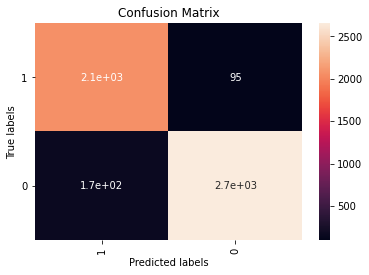

In [25]:
def my_classification_report(y_actual , y_predicted):
    print(classification_report(y_actual, y_pred))
    acc = accuracy_score(y_actual , y_predicted)
    print('accuracy : {}'.format(acc))
   
    conf_mat=confusion_matrix(y_actual, y_pred)
    #print(conf_mat)
    #plt.figure(figsize=(20,20))
    ax = plt.subplot()
    sns.heatmap(conf_mat, annot=True, ax = ax); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(['1','0'])
    ax.yaxis.set_ticklabels(['1','0'])
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    #plt.savefig('conf_matrix.png')
    plt.show()

y_actual = y_actual.cpu().detach().numpy()
y_pred = y_pred.cpu().detach().numpy()
my_classification_report(y_actual = y_actual , y_predicted = y_pred)